<a href="https://colab.research.google.com/github/AndreaCamilloni/BTC-price-prediction/blob/main/Official_NAML_project_BTC_price_prediction_Camilloni%2C_Cercola%2C_Giacometti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BITCOIN PRICE PREDICTION

In [662]:
TRAINING = False #set True if you want to re-train the models, otherwise weights from previous training are loaded

## Import libraries

In [663]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [664]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import plotly.graph_objs as go
import pylab as p

import yfinance as yf

import sklearn.preprocessing as skp
import sklearn.svm as sks

from statsmodels.tsa.stattools import adfuller

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
import keras.callbacks as callbacks 

## Data download

The first step consists in downloading the dataset. We will utilize Bitcoin daily information from 1 January 2017 to 31 October 2020. Data is collected from Yahoo Finance.

In [665]:
start_date = '2017-01-01'
end_date = '2020-10-31'

# Get Bitcoin data
data = yf.download(tickers='BTC-USD',  interval = '1d', start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


## Data Analysis

Each row of the dataset correspond to a day and contains the following information:
* Open : the opening price
* High : the highest price reached in that day
* Low : the lowest price reached in that day
* Close : the closing price
* Adj Close : the adjusted closing price
* Volume : daily trading volume






In [666]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


Since close and adjusted close values are the same, we drop the latter.



In [667]:
close = data.to_numpy()[:,3]
adjclose = data.to_numpy()[:,4]
np.linalg.norm(close-adjclose)

0.0

In [668]:
data = data.drop(columns = "Adj Close")

Some descriptive statistics about the dataset.

In [669]:
data.describe()

,Open,High,Low,Close,Volume
count,1400.000000,1400.000000,1400.000000,1400.000000,1.400000e+03
mean,7000.318304,7176.542994,6814.025538,7009.357637,1.355049e+10
std,3477.919243,3586.625847,3346.254999,3479.000586,1.322634e+10
min,775.177979,823.307007,755.755981,777.757019,6.085170e+07
25%,4034.975525,4112.052612,3969.464722,4045.500977,3.671792e+09
50%,7241.401611,7388.366455,7081.487305,7247.584473,7.985649e+09
75%,9382.161377,9553.655029,9233.236084,9388.309814,2.077375e+10
max,19475.800781,20089.000000,18974.099609,19497.400391,7.415677e+10


The following chart displays Bitcoin price evolution.

If the opening price is higher than the closing price, the box is filled in red, whereas if the closing price is higher than the opening price, the box is green. 

This type of plot is relevant because it shows the volatility of the stock within a trading day. 

In [670]:
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=data.index,open=data['Open'],high=data['High'],low=data['Low'],close=data['Close'], name = 'market data'))

# Add titles
fig.update_layout(title='Bitcoin live share price evolution',yaxis_title='Bitcoin Price (kUS Dollars)')

# X-Axes
fig.update_xaxes(rangeslider_visible=True,rangeselector=dict(
  buttons=list([
          dict(count=15, label="15m", step="minute", stepmode="backward"),
          dict(count=45, label="45m", step="minute", stepmode="backward"),
          dict(count=1, label="HTD", step="hour", stepmode="todate"),
          dict(count=6, label="6h", step="hour", stepmode="backward"),
          dict(step="all")
          ])))

We are interested in predicting the closing price. We plot its values over the time interval.

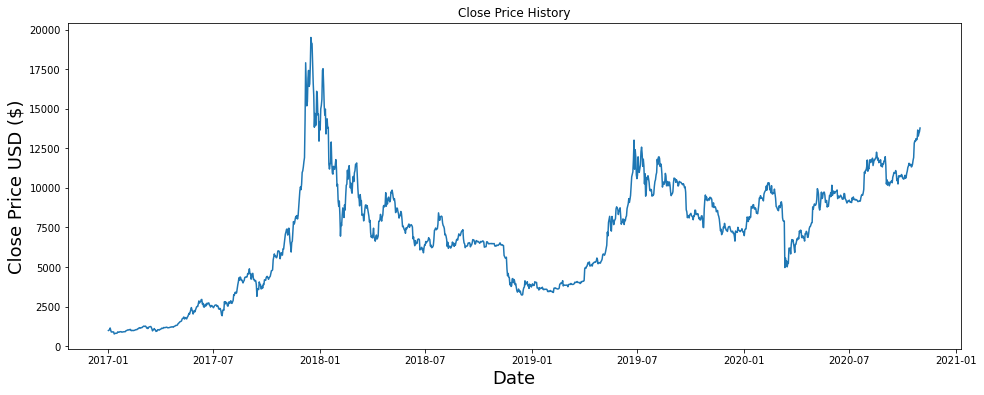

In [671]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(data.Close)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

We now plot close prices median across years in order to visualize its main trend.




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



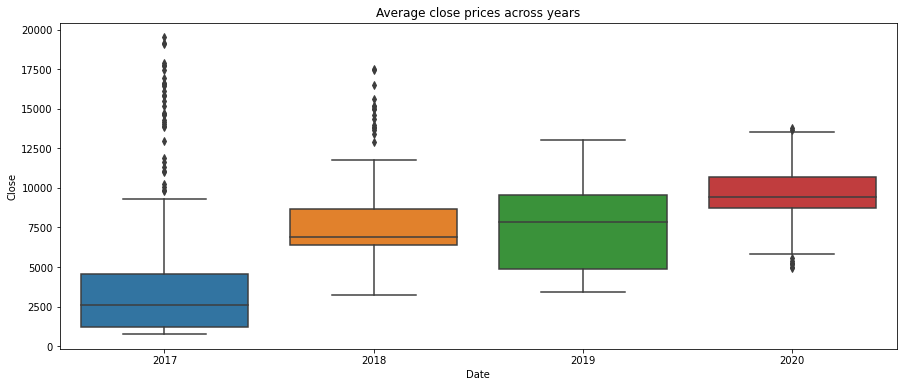

In [672]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Average close prices across years")
sns.boxplot(pd.PeriodIndex(data.index, freq='Y'), data.Close, ax=ax)

### Stationarity

A time series is said to be stationary if its properties are time independent.

Stationary time series are therefore characterized by constant mean and covariance. They tend to vary around a fixed level and they do not present any kind of trend or seasonal component.

Bitcoin close price time series is clearly not stationary, due to its massive fluctuations. Even if it is evident just by visualizing the plot, we can apply the Augmented Dickey-Fuller test in order to draw more precise conclusions.

#### Augmented Dickey-Fuller Test
The Augmented Dickey-Fuller test is a statistical test employed to check if a time series is stationary. As for the hypothesis:

*  Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. 

*  Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary.


We perfomed the test through the function *adfuller* provided by *statsmodel* library.

We consider the null hypothesis rejected, hence the time series stationary, when the test statistic is lower than the 5% critical value.

In [673]:
def is_stationary(time_series, critical_value = 1): #critical values: 0 = 1%, 1 = 5%, 2 = 10%
        
    test_result = adfuller(time_series)

    test_statistic = test_result[0]
    critical_values = list(test_result[4].values())

    print('ADF test statistic: %f' %test_statistic)
    print('Critical values:')
    for key,value in test_result[4].items():
        print('\t%s: %.3f ' % (key, value))

    if test_statistic > critical_values[critical_value]:
      print("The timeseries is not stationary")
    else:
      print("The timeseries is stationary")

In [674]:
is_stationary(data.Close, 1)

ADF test statistic: -2.263287
Critical values:
	1%: -3.435 
	5%: -2.864 
	10%: -2.568 
The timeseries is not stationary


The results of the test confirms that the timeseries is not stationary.

## Prediction with non stationary data

In this section we propose two different architectures, both trained on the original time series (containing non stationary data).

Proposed models will implement two differents method:
*   $LSTM_{ns}$ (Long short time memory)
*   $SVR_{ns}$ (Support vector regression)

### $LSTM_{ns}$

#### Preprocess

Parameters of the model.

In [675]:
TIME_LAGS = 7 #number of points that define the lstm input
FINAL_DATE_TRAIN = '31-05-2020'
VALIDATION_SPLIT = 0.2 #over training set
COLUMN_TO_PREDICT = 3 #close column
NUM_FEATURES = 5

Function that rearranges data in the shape requested for the prediction.

In [676]:
def create_dataset_lstm(dataset, lags, column):
  x = []
  y = []
  for i in range(lags, len(dataset)):
    x.append(dataset[i-lags:i])
    y.append(dataset[i, column])

  x = np.array(x)
  return np.reshape(x,(x.shape[0], x.shape[1], NUM_FEATURES)), np.array(y)

Data is then split in training, test and validation sets:
*  training data is collected up to '31-05-2020' and 20% of it was retained for validation purposes.
*  remaining samples are used for testing 

Since we are dealing with time series we will not shuffle the samples.

In [677]:
train_size = data[:FINAL_DATE_TRAIN].shape[0]
                  

train_df = data[:train_size] 
test_df = data[train_size - TIME_LAGS:] 


print("Train size: ", train_size-int(train_size*VALIDATION_SPLIT) )
print("Validation size: ", int(train_size*VALIDATION_SPLIT) )
print("Test size: ", data.shape[0] - train_size)

Train size:  998
Validation size:  249
Test size:  153


Training data are scaled between 0 and 1 in order to ease the training phase. Then, we use the fitted scaler to transform test data as well.

In [678]:
scaler_lstm = skp.MinMaxScaler()
scaled_train = scaler_lstm.fit_transform(train_df)
scaled_test = scaler_lstm.transform(test_df) 

Final datasets are created through *create_dataset* function.


In [679]:
x_train, y_train = create_dataset_lstm(scaled_train, TIME_LAGS, COLUMN_TO_PREDICT)
x_test, y_test = create_dataset_lstm(scaled_test, TIME_LAGS, COLUMN_TO_PREDICT)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1240, 7, 5), (1240,), (153, 7, 5), (153,))

x_train and x_test are matrices whose dimensions are *n_samples*  by *TIME_LAGS* by *NUM_FEATURES*. 

Each row contains the *TIME_LAGS* previous observation of the respective y element in the same row.

 In this way, we lose the first *TIME_LAGS* observations ( which can't be predicted since they do not have enough previous observations).

#### Model

Build LSTM model.

In [680]:
BATCH_SIZE = 64
NUMBER_OF_EPOCHS = 20

In [681]:
model_ns = Sequential()
model_ns.add(LSTM(units=256, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], NUM_FEATURES)))
model_ns.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], NUM_FEATURES)))
model_ns.add(Dense(16, activation = "relu"))
model_ns.add(Dense(32, activation = "relu"))
model_ns.add(Dense(16, activation = "relu"))
model_ns.add(LSTM(units=64, activation='relu', return_sequences=True))
model_ns.add(LSTM(units=32, activation='relu', return_sequences=True))
model_ns.add(Dense(16, activation = "relu"))
model_ns.add(Dense(32, activation = "relu"))
model_ns.add(Dense(16, activation = "relu"))
model_ns.add(LSTM(units=16, activation='relu', return_sequences=True))
model_ns.add(LSTM(units=8, activation='relu'))
model_ns.add(Dense(units=1))

# Compile the model
model_ns.compile(optimizer='adam', loss='mean_squared_error')

#### Train

Train the model through training set.

In [682]:
# Train the model
if TRAINING:
  history = model_ns.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = NUMBER_OF_EPOCHS, validation_split = VALIDATION_SPLIT, verbose = 1, shuffle = True)
  history_ns = history.history

else: 
  #load the previous history
  url_history_ns = 'https://raw.githubusercontent.com/AndreaCamilloni/BTC-price-prediction/main/saved_models/history_lstm_ns.csv'
  history_ns = pd.read_csv(url_history_ns)
  
  #load the previous weights
  url = f"https://raw.githubusercontent.com/AndreaCamilloni/BTC-price-prediction/main/saved_models/lstm_nonstat_weights.h5"
  !wget --no-cache --backups=1 {url}


  model_ns.load_weights('lstm_nonstat_weights.h5')

--2022-06-15 10:16:46--  https://raw.githubusercontent.com/AndreaCamilloni/BTC-price-prediction/main/saved_models/lstm_nonstat_weights.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2076960 (2.0M) [application/octet-stream]
Saving to: ‘lstm_nonstat_weights.h5’

lstm_nonstat_weight 100%[===================>]   1.98M  --.-KB/s    in 0.06s   

2022-06-15 10:16:46 (31.5 MB/s) - ‘lstm_nonstat_weights.h5’ saved [2076960/2076960]



In [683]:
#For saving models and history

#model_ns.save_weights('lstm_nonstat_weights.h5')

#hist_df = pd.DataFrame(history.history) 
#hist_csv_file = 'history_lstm_ns.csv' 
#with open(hist_csv_file, mode='w') as f:
#    hist_df.to_csv(f)
#else: load history

Plot training and validation losses

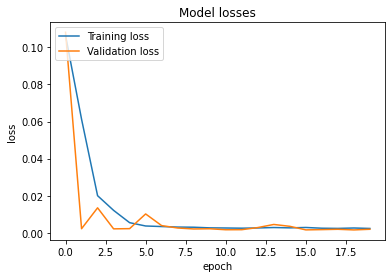

In [684]:
plt.plot(history_ns['loss'], label = "Training loss")
plt.plot(history_ns['val_loss'], label = "Validation loss")
plt.title('Model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

#### Predict

Predict new values from test data.

In [685]:
predictions = model_ns.predict(x_test)

#### Result

Scale back predictions and test targets.

In [686]:
scale = 1 / scaler_lstm.scale_[COLUMN_TO_PREDICT]
y_test_scaled_lstm = y_test * scale
predictions_scaled_lstm = predictions * scale
predictions_scaled_lstm = predictions_scaled_lstm.reshape(-1)

Function to compute and print losses.

In [687]:
def movement_accuracy(t, p):
  acc = 0
  length = t.shape[0] - 1 
  for i in range(0, length ):
    trend_test = t[i+1] - t[i]
    trend_pred = p[i+1] - p[i]
    if np.sign(trend_test) == np.sign(trend_pred):
      acc += 1

  return acc/length * 100

def print_losses(t,p):
  rmse = np.sqrt(np.mean((p - t) ** 2))
  mae = np.mean(np.abs(p - t))
  mov_acc = movement_accuracy(t,p)

  print("MAE: %1.3f" % mae)
  print("RMSE: %1.3f" % rmse)
  print("Movement accuracy: %1.1f %%" % mov_acc)
  return rmse, mae, mov_acc


In [688]:
result_lstm = print_losses(y_test_scaled_lstm, predictions_scaled_lstm)

MAE: 410.405
RMSE: 571.489
Movement accuracy: 54.6 %


Visualize predictions and test values.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



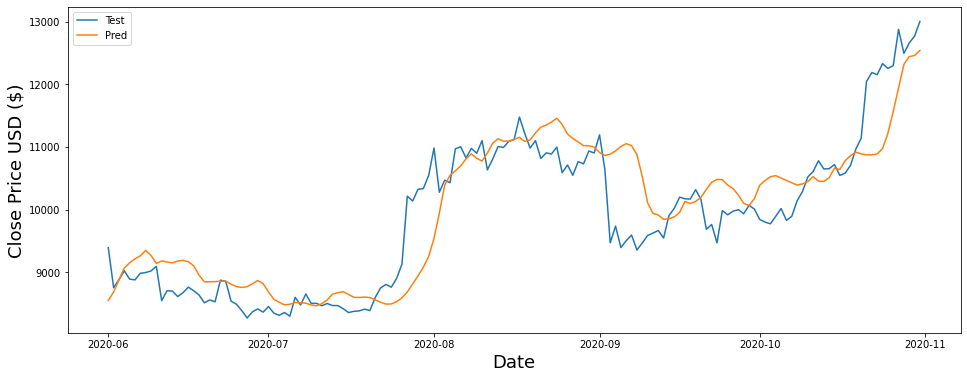

In [689]:
# Visualize the data
df_plt = test_df[TIME_LAGS:]
df_plt['y_test'] = y_test_scaled_lstm
df_plt['Predictions-LSTM'] = predictions_scaled_lstm
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_plt['y_test'],label = "Test")
plt.plot(df_plt['Predictions-LSTM'],label = "Pred")
plt.legend()
plt.show()

### $SVR_{ns}$

#### Preprocess

We define a new function to assemble the dataset, with the same purpose of the other one. Since we are trying to make a regression, the x output will be a two-dimensional matrix.

In [690]:
def create_dataset_svr(dataset, lags, column):
  x = []
  y = []

  for i in range(lags, len(dataset)):
    x.append(dataset[i-lags:i])
    y.append(dataset[i,0])

  x = np.array(x)
  return np.reshape(x,(x.shape[0], x.shape[1])), np.array(y)

We'll use only close prices values to perform the prediction. We save them into a variable and split between train and test sets.

In [691]:
close_values = data.Close.to_numpy()
train_data_svr = close_values[0:train_size]
test_data_svr = close_values[train_size-TIME_LAGS:]

We scale training data between 0 and 1. Then, we use the fitted scaler to transform also the test set.

In [692]:
scaler_svr = skp.MinMaxScaler()
scaled_train_svr = scaler_svr.fit_transform(train_data_svr.reshape(-1,1))
scaled_test_svr = scaler_svr.transform(test_data_svr.reshape(-1,1))

Finally, we create the datasets.

In [693]:
x_train_svr, y_train_svr = create_dataset_svr(scaled_train_svr, TIME_LAGS, COLUMN_TO_PREDICT)
x_test_svr, y_test_svr = create_dataset_svr(scaled_test_svr, TIME_LAGS, COLUMN_TO_PREDICT)

x_train_svr.shape, y_train_svr.shape, x_test_svr.shape, y_test_svr.shape

((1240, 7), (1240,), (153, 7), (153,))

#### Model

Parameter of the SVR model.

In [694]:
GAMMA = 0.01
C = 0.1
EPSILON = 0.001
KERNEL = 'rbf'

Define the model.

In [695]:
svr = sks.SVR(kernel = KERNEL, gamma=GAMMA, C = C, epsilon = EPSILON)

#### Train

Train with training set.

In [696]:
svr.fit(x_train_svr, y_train_svr)

SVR(C=0.1, epsilon=0.001, gamma=0.01)

#### Predict

Perform prediction and reshape the output in order to be fed into the scaler (which requires a matrix as input) and obtain scaled results.

In [697]:
predictions_svr = svr.predict(x_test_svr)
predictions_svr = np.reshape(predictions_svr, (predictions_svr.shape[0], 1) )

#### Result

Scale back data.

In [698]:
predictions_scaled_svr = scaler_svr.inverse_transform(predictions_svr)
y_test_scaled_svr = scaler_svr.inverse_transform(y_test_svr.reshape(-1,1))
pred_scaled_svr = predictions_scaled_svr.reshape(-1)

Visualize predictions.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



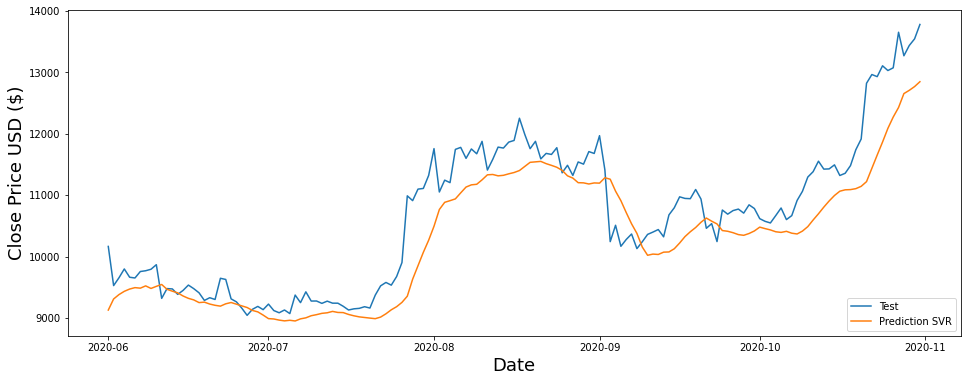

In [699]:
df_plt['Predictions-SVR'] = predictions_scaled_svr
df_plt['y_test_svr'] = y_test_scaled_svr

plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_plt['y_test_svr'], label = "Test")
plt.plot(df_plt['Predictions-SVR'], label = "Prediction SVR")
plt.legend(loc='lower right')
plt.show()

Print losses to evaluate the performance of the model

In [700]:
result_svr = print_losses(y_test_scaled_svr, predictions_scaled_svr)

MAE: 425.697
RMSE: 547.378
Movement accuracy: 50.7 %


### Comparison



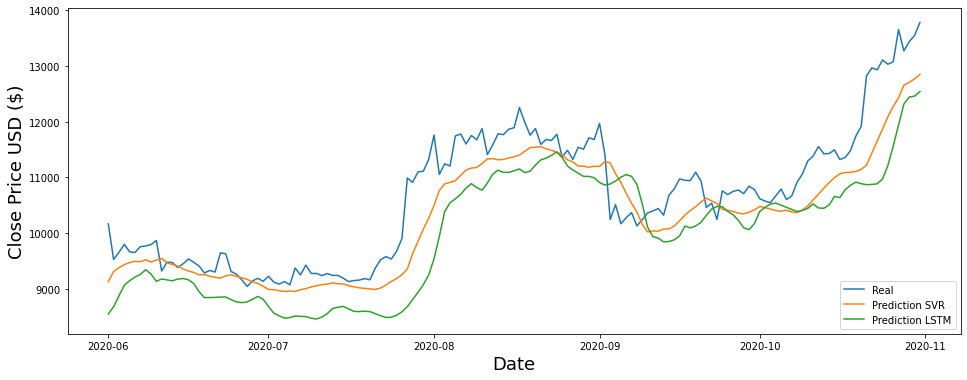

In [701]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_plt['Close'], label = "Real")
plt.plot(df_plt['Predictions-SVR'], label = "Prediction SVR")
plt.plot(df_plt['Predictions-LSTM'], label = "Prediction LSTM")
plt.legend( loc='lower right')
plt.show()

In [702]:
result = pd.DataFrame({"LSTM" : result_lstm, "SVR" :result_svr })
result.index = ["RMSE", "MAE", "ACCURACY"]

result

,LSTM,SVR
RMSE,571.488948,547.377699
MAE,410.405333,425.696812
ACCURACY,54.605263,50.657895


## Prediction with stationary data - $LSTM_{s}$

Get close column.

In [703]:
close = data.Close.to_numpy()

Define differencing order parameter.

In [704]:
D = 0.3

Function to compute fractional difference of a given timeseries and differencing order.

In [705]:
def frac_diff(x, d):
    
    n = len(x)

    # calculate weights
    weights = [0] * n
    weights[0] = -d
    for k in range(2, n):
        weights[k - 1] = weights[k - 2] * (k - 1 - d) / k

    # difference series
    ydiff = list(x)

    for i in range(0, n):
        dat = x[:i]
        w = weights[:i]
        ydiff[i] = x[i] + np.dot(w, dat[::-1])

    return np.array(ydiff)

Compute fractional differences of train and test data.

In [706]:
frac_diff_train = frac_diff(close[:train_size], D)
frac_diff_test = frac_diff(close[train_size - TIME_LAGS:], D)

Check that both timeseries are stationary.

ADF test statistic: -3.582658
Critical values:
	1%: -3.436 
	5%: -2.864 
	10%: -2.568 
The timeseries is stationary


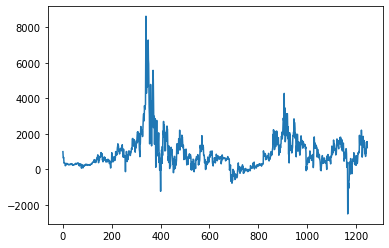

In [707]:
plt.plot(frac_diff_train)
is_stationary(frac_diff_train)

ADF test statistic: -5.988612
Critical values:
	1%: -3.472 
	5%: -2.880 
	10%: -2.577 
The timeseries is stationary


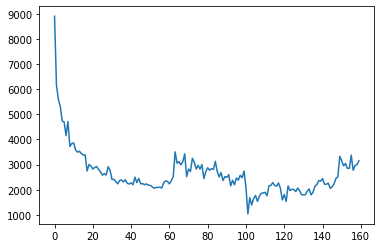

In [708]:
plt.plot(frac_diff_test)
is_stationary(frac_diff_test)

Reconstruct both the original timeseries by computing the fractional difference with the opposite sign order.

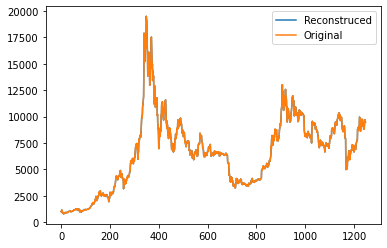

In [709]:
plt.plot(frac_diff(frac_diff_train,-D), label = "Reconstruced")
plt.plot(close[:train_size], label = "Original")
plt.legend()

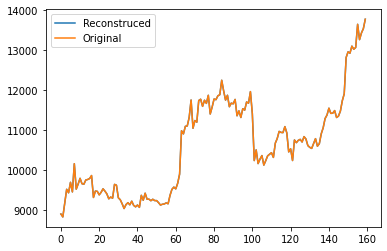

In [710]:
plt.plot(frac_diff(frac_diff_test,-D), label = "Reconstruced")
plt.plot(close[train_size - TIME_LAGS:], label = "Original")
plt.legend()

Normalize training data between max and min and apply the transformation also to the test set.

In [711]:
min = frac_diff_train.min()
max = frac_diff_train.max()
scaled_stat_train = (frac_diff_train - min) / (max-min)
scaled_stat_test = (frac_diff_test - min) / (max-min)

In [712]:
def create_dataset_staz(dataset, lags):
  x = []
  y = []
  for i in range(lags, len(dataset)):
    x.append(dataset[i-lags:i])
    
    y.append(dataset[i])

  x = np.array(x)
  
  return np.reshape(x,(x.shape[0], x.shape[1], 1)), np.array(y)

In [713]:
x_train_staz, y_train_staz = create_dataset_staz(scaled_stat_train, TIME_LAGS)
x_test_staz, y_test_staz = create_dataset_staz(scaled_stat_test, TIME_LAGS)

x_train_staz.shape, y_train_staz.shape, x_test_staz.shape, y_test_staz.shape

((1240, 7, 1), (1240,), (153, 7, 1), (153,))

Create model

In [714]:
BATCH_SIZE_STAZ = 64
NUM_EPOCHS_STAZ = 10

In [715]:
model_s = Sequential()

model_s.add(LSTM(units = 128,return_sequences=True, input_shape= (x_train_staz.shape[1], 1)))
model_s.add(LSTM(units = 64,return_sequences=True, input_shape= (x_train_staz.shape[1], 1)))
model_s.add(LSTM(units = 32,return_sequences=True, input_shape= (x_train_staz.shape[1], 1)))
model_s.add(LSTM(units = 16,return_sequences=False, input_shape= (x_train_staz.shape[1], 1))) 

# model_s.add(Dense(16, activation = "relu"))
# model_s.add(Dense(32, activation = "relu"))
# model_s.add(Dense(16, activation = "relu"))
model_s.add(Dense(units = 1))

model_s.compile(optimizer = 'adam', loss = 'mean_squared_error')


Train

In [716]:
# Train the model
if TRAINING:
  history_stat = model_s.fit(x_train_staz, y_train_staz, batch_size=BATCH_SIZE_STAZ, epochs=NUM_EPOCHS_STAZ,validation_split=VALIDATION_SPLIT, verbose=1, shuffle=True)
  history_s = history_stat.history

else: 
  #load the previous history
  url_history_s = 'https://raw.githubusercontent.com/AndreaCamilloni/BTC-price-prediction/main/saved_models/history_lstm_s.csv'
  history_s = pd.read_csv(url_history_s)
  
  #load the previous weights
  url_model_stat = f"https://raw.githubusercontent.com/AndreaCamilloni/BTC-price-prediction/main/saved_models/lstm_stat_weights.h5"
  !wget --no-cache --backups=1 {url_model_stat}


  model_s.load_weights('lstm_stat_weights.h5')

 # Train the model

--2022-06-15 10:16:54--  https://raw.githubusercontent.com/AndreaCamilloni/BTC-price-prediction/main/saved_models/lstm_stat_weights.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 552600 (540K) [application/octet-stream]
Saving to: ‘lstm_stat_weights.h5’

lstm_stat_weights.h 100%[===================>] 539.65K  --.-KB/s    in 0.04s   

2022-06-15 10:16:54 (11.8 MB/s) - ‘lstm_stat_weights.h5’ saved [552600/552600]



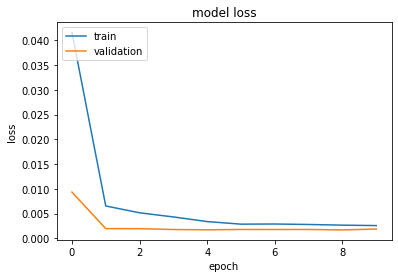

In [717]:
plt.plot(history_s['loss'])
plt.plot(history_s['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [718]:
predictions_stat = model_s.predict(x_test_staz)

In [719]:
#model_s.save_weights('lstm_stat_weights.h5')

#hist_stat = pd.DataFrame(history_stat.history) 
#hist_csv_file = 'history_lstm_s.csv' 
#with open(hist_csv_file, mode='w') as f:
#    hist_stat.to_csv(f)


In [720]:
y_test_staz_rec = np.concatenate((scaled_stat_test[:TIME_LAGS], y_test_staz))
predictions_reconstructed = np.concatenate((scaled_stat_test[:TIME_LAGS], predictions_stat.reshape(predictions_stat.shape[0])))

predictions_scaled = predictions_reconstructed*(max-min)+min
y_test_scaled = y_test_staz_rec *(max-min)+min

In [721]:
predictions_original_stat = frac_diff(predictions_scaled,-D)
y_original_stat = frac_diff(y_test_scaled,-D)

In [722]:
result_stationary_lstm = print_losses(y_original_stat[TIME_LAGS:], predictions_original_stat[TIME_LAGS:])

MAE: 503.407
RMSE: 636.194
Movement accuracy: 52.0 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



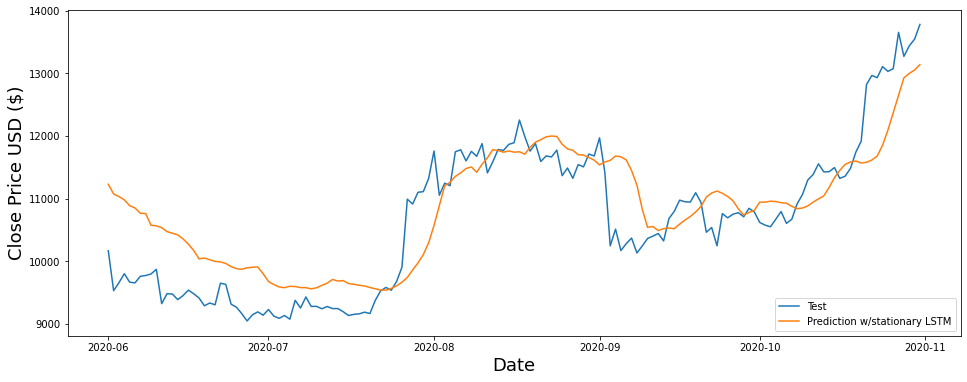

In [723]:
df_plt['Stationary LSTM'] = predictions_original_stat[TIME_LAGS:]
df_plt['Y test stat'] = y_original_stat[TIME_LAGS:]

plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_plt['Y test stat'], label = "Test")
plt.plot(df_plt['Stationary LSTM'], label = "Prediction w/stationary LSTM")
plt.legend(loc='lower right')
plt.show()

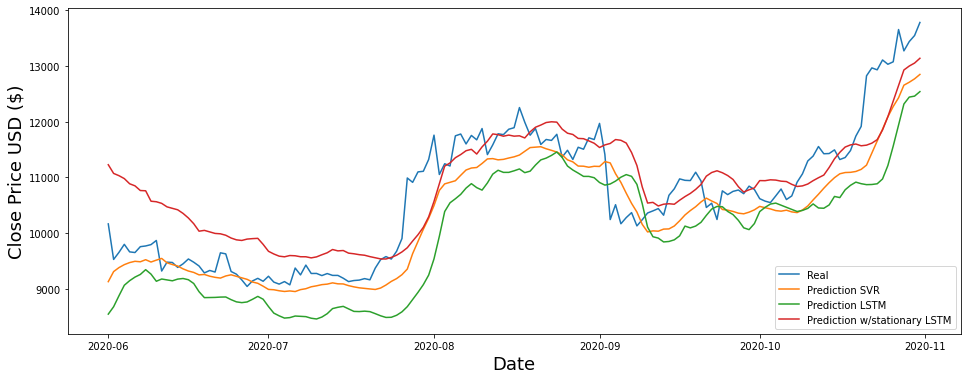

In [724]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_plt['Close'], label = "Real")
plt.plot(df_plt['Predictions-SVR'], label = "Prediction SVR")
plt.plot(df_plt['Predictions-LSTM'], label = "Prediction LSTM")
plt.plot(df_plt['Stationary LSTM'], label = "Prediction w/stationary LSTM")
plt.legend( loc='lower right')
plt.show()

In [725]:
result = pd.DataFrame({"LSTM" : result_lstm, "SVR" :result_svr,"Stationary LSTM" : result_stationary_lstm })
result.index = ["RMSE", "MAE", "ACCURACY"]

result

,LSTM,SVR,Stationary LSTM
RMSE,571.488948,547.377699,636.193986
MAE,410.405333,425.696812,503.406959
ACCURACY,54.605263,50.657895,51.973684
